In [1]:
import math
from typing import *
from uuid import uuid4
from process_bigraph import Process, Composite, pf, pp
from biosimulators_processes import CORE
from biosimulators_processes.data_model.sed_data_model import MODEL_TYPE
try:
    import smoldyn as sm
    from smoldyn._smoldyn import MolecState
except:
    raise ImportError(
        '\nPLEASE NOTE: Smoldyn is not correctly installed on your system which prevents you from ' 
        'using the SmoldynProcess. Please refer to the README for further information '
        'on installing Smoldyn.'
    )


class SmoldynIOProcess(Process):
    """
    Parameters:
        model: model: {model_source: INPUT FILEPATH, ...}
        duration: simulation duration (int)
        output_dest: tmp output dir (str)
    """
    config_schema = {
        'model': MODEL_TYPE,
        # 'duration': 'integer',  # duration should instead be inferred from Composite
        'output_dest': 'string',
        'animate': {
            '_type': 'boolean',
            '_default': False
        }
    }

    def __init__(self, config: dict = None, core=CORE):
        super().__init__(config, core)

        # get params
        input_filepath = self.config.get('model').get('model_source')
        input_filename = input_filepath.split('/')[-1]
        output_dest = self.config['output_dest']
        self.model_filepath = os.path.join(output_dest, input_filename)
        # self.duration = self.config['duration']

        # write the uploaded file to save dest(temp)
        with open(input_filepath, 'r') as source_file:
            with open(self.model_filepath, 'w') as model_file:
                # Read from the source file and write to the destination
                model_file.write(source_file.read())

        # get the appropriate output filepath
        self.output_filepath = self.handle_output_commands()
            
        # enforce model filepath passing
        if not self.model_filepath:
            raise ValueError(
                '''
                    The Process configuration requires a Smoldyn model filepath to be passed.
                    Please specify a 'model_filepath' in your instance configuration.
                '''
            )

        # initialize the simulator from a Smoldyn MinE.txt file.
        self.simulation: sm.Simulation = sm.Simulation.fromFile(self.model_filepath)

        # get a list of the simulation species
        species_count = self.simulation.count()['species']
        self.species_names: List[str] = []
        for index in range(species_count):
            species_name = self.simulation.getSpeciesName(index)
            if 'empty' not in species_name.lower():
                self.species_names.append(species_name)
        # sort for logistical mapping to species names (i.e: ['a', 'b', c'] == ['0', '1', '2']
        self.species_names.sort()
        self.port_schema = {'output_filepath': 'string'}
        self.boundaries: Dict[str, List[float]] = dict(zip(['low', 'high'], self.simulation.getBoundaries()))
        self.interval = 0

    def set_uniform(
            self,
            species_name: str,
            count: int,
            kill_mol: bool = True
            ) -> None:
        """Add a distribution of molecules to the solution in
            the simulation memory given a higher and lower bound x,y coordinate. Smoldyn assumes
            a global boundary versus individual species boundaries. Kills the molecule before dist if true.

            TODO: If pymunk expands the species compartment, account for
                  expanding `highpos` and `lowpos`. This method should be used within the body/logic of
                  the `update` class method.

            Args:
                species_name:`str`: name of the given molecule.
                count:`int`: number of molecules of the given `species_name` to add.
                kill_mol:`bool`: kills the molecule based on the `name` argument, which effectively
                    removes the molecule from simulation memory.
        """
        # kill the mol, effectively resetting it
        if kill_mol:
            self.simulation.runCommand(f'killmol {species_name}')

        # TODO: eventually allow for an expanding boundary ie in the configuration parameters (pymunk?), which is defies the methodology of smoldyn

        # redistribute the molecule according to the bounds
        self.simulation.addSolutionMolecules(
            species=species_name,
            number=count,
            highpos=self.boundaries['high'],
            lowpos=self.boundaries['low']
        )

    def initial_state(self) -> Dict[str, Union[int, Dict]]:
        """Set the initial parameter state of the simulation. This method should return an implementation of
            that which is returned by `self.schema()`.


        NOTE: Due to the nature of this model,
            Smoldyn assigns a random uniform distribution of integers as the initial coordinate (x, y, z)
            values for the simulation. As such, the `set_uniform` method will uniformly distribute
            the molecules according to a `highpos`[x,y] and `lowpos`[x,y] where high and low pos are
            the higher and lower bounds of the molecule spatial distribution.

            NOTE: This method should provide an implementation of the structure denoted in `self.schema`.
        """
        return {}

    def inputs(self):
        return {}

    def outputs(self):
        return self.port_schema

    def update(self, inputs: Dict, interval: int) -> Dict:
        """Callback method to be evoked at each Process interval. We want to get the
            last of each dataset type as that is the relevant data in regard to the Process timescale scope.

            Args:
                inputs:`Dict`: current state of the Smoldyn simulation, expressed as a `Dict` whose
                    schema matches that which is returned by the `self.schema()` API method.
                interval:`int`: Analogous to Smoldyn's `time_stop`, this is the
                    timestep interval at which to provide the update as the output of this method.
                    NOTE: This update is iteratively called with the `Process` API.

            Returns:
                `Dict`: New state according to the update at interval


            TODO: We must account for the mol_ids that are generated in the output based on the interval run,
                i.e: Shorter intervals will yield both less output molecules and less unique molecule ids.
        """
        # get current counts state from simulator instance
        species_counts = {
            spec_name: self.simulation.getMoleculeCount(spec_name, MolecState.all)
            for spec_name in self.species_names
        }

        # reset the molecules, distribute the mols according to self.boundarieså
        for name in self.species_names:
            # TODO: find a better MolecState to use
            current_species_count = self.simulation.getMoleculeCount(name, MolecState.all)
            self.set_uniform(
                species_name=name,
                count=current_species_count,
                kill_mol=True
            )

        # run the simulation for a given interval
        # self.simulation.run(
        #     stop=interval + 1,
        #     dt=self.simulation.dt
        # )
        self.simulation.runSim()

        # rewrite the modelout to a unique name
        outfile = self.output_filepath.split('/')[-1]
        output_filename = str(self.interval) + "_" + outfile
        output_filepath = self.output_filepath.replace(outfile, output_filename)
        self.interval += 1
        
        # return the modelout file
        return {'output_filepath': output_filepath}


    def read_smoldyn_simulation_configuration(self, filename) -> list[str]:
        ''' Read a configuration for a Smoldyn simulation
    
        Args:
            filename (:obj:`str`): path to model file
    
        Returns:
            :obj:`list` of :obj:`str`: simulation configuration
        '''
        with open(filename, 'r') as file:
            return [line.strip('\n') for line in file]
    
    def write_smoldyn_simulation_configuration(self, configuration, filename) -> None:
        ''' Write a configuration for Smoldyn simulation to a file
    
        Args:
            configuration
            filename (:obj:`str`): path to save configuration
        '''
        with open(filename, 'w') as file:
            for line in configuration:
                file.write(line)
                file.write('\n')

    def handle_output_commands(self) -> str:
        model_fp = self.model_filepath
        duration = 1
        config = self.read_smoldyn_simulation_configuration(model_fp)
        has_output_commands = any([v.startswith('output') for v in config])
        if not has_output_commands:
            cmd_i = 0
            for i, v in enumerate(config):
                if v == 'end_file':
                    cmd_i += i - 1
                stop_key = 'time_stop'
                
                if f'define {stop_key.upper()}' in v:
                    new_v = f'define TIME_STOP   {duration}'
                    config.remove(config[i])
                    config.insert(i, new_v)
                elif v.startswith(stop_key):
                    new_v = f'time_stop TIME_STOP'
                    config.remove(config[i])
                    config.insert(i, new_v)
            cmds = ["output_files modelout.txt",
                    "cmd i 0 TIME_STOP 1 executiontime modelout.txt",
                    "cmd i 0 TIME_STOP 1 listmols modelout.txt"]
            current = cmd_i 
            for cmd in cmds:
                config.insert(current, cmd)
                current += 1 
        
        self.write_smoldyn_simulation_configuration(config, model_fp) 
        
        out_filepath = model_fp.replace(model_fp.split('/')[-1].split('.')[0], 'modelout')
        return out_filepath

    def _new_difc(self, t, args):
        minD_count, minE_count = args
        # TODO: extract real volume
        volume = 1.0

        # Calculate concentrations from counts
        minD_conc = minD_count / volume
        minE_conc = minE_count / volume

        # for example: diffusion coefficient might decrease with high MinD-MinE complex formation
        minDE_complex = minD_conc * minE_conc  # Simplified interaction term
        base_diffusion = 2.5  # Baseline diffusion coefficient

        # perturb the parameter of complex formation effect slightly
        _alpha = 0.1
        delta = _alpha - (_alpha ** 10)
        alpha = _alpha - delta

        new_difc = base_diffusion * (1 - alpha * minDE_complex)

        # Ensure the diffusion coefficient remains within a reasonable range
        new_difc = max(min(new_difc, base_diffusion), 0.01)  # Adjust bounds as needed

        return new_difc


CORE.process_registry.register('smoldyn-io-process', SmoldynIOProcess)

Cannot register CobraProcess. Error:
**
No module named 'processes'
**


In [1]:
import math
from typing import *
from uuid import uuid4
from process_bigraph import Process, Composite, pf, pp
from biosimulators_processes import CORE
from biosimulators_processes.data_model.sed_data_model import MODEL_TYPE
try:
    import smoldyn as sm
    from smoldyn._smoldyn import MolecState
except:
    raise ImportError(
        '\nPLEASE NOTE: Smoldyn is not correctly installed on your system which prevents you from ' 
        'using the SmoldynProcess. Please refer to the README for further information '
        'on installing Smoldyn.'
    )

Cannot register CobraProcess. Error:
**
No module named 'processes'
**


In [2]:
CORE.process_registry.registry

{'console-emitter': process_bigraph.composite.ConsoleEmitter,
 'ram-emitter': process_bigraph.composite.RAMEmitter,
 'composite': process_bigraph.composite.Composite,
 'copasi-process': biosimulators_processes.processes.copasi_process.CopasiProcess,
 'tellurium-process': biosimulators_processes.processes.tellurium_process.TelluriumProcess,
 'utc-amici': biosimulators_processes.processes.amici_process.UtcAmici,
 'utc-copasi': biosimulators_processes.processes.copasi_process.UtcCopasi,
 'utc-tellurium': biosimulators_processes.processes.tellurium_process.UtcTellurium,
 'smoldyn-process': biosimulators_processes.processes.smoldyn_process.SmoldynProcess,
 'smoldyn-io-process': biosimulators_processes.processes.smoldyn_process.SmoldynIOProcess,
 'copasi-step': biosimulators_processes.steps.ode_simulation.CopasiStep,
 'tellurium-step': biosimulators_processes.steps.ode_simulation.TelluriumStep,
 'amici-step': biosimulators_processes.steps.ode_simulation.AmiciStep,
 'plotter': biosimulators_p

In [3]:
import tempfile
import os
from process_bigraph import Composite

fp = 'examples/smoldyn/MinE.txt'
dest = tempfile.mkdtemp()
duration = 10
name = 'smoldyn'


doc = {
    name: {
        '_type': 'process',
        'address': f'local:smoldyn-io-process',
        'config': {
            'model': {
                'model_source': fp
            }
        },
        'inputs': {},
        'outputs': {
            'output_filepath': ['output_filepath_store']
        }
    },
    'emitter': {
        '_type': 'step',
        'address': 'local:ram-emitter',
        'config': {
            'emit': {
                'output_filepath': 'string',
            }
        },
        'inputs': {
            'output_filepath': ['output_filepath_store']
        }
    }
}

composite = Composite({
    'state': doc,
    # 'emitter': {'mode': 'all'}
}, core=CORE)

In [4]:
composite.run(5)

print(composite.gather_results())

{('emitter',): [{'output_filepath': ''}, {'output_filepath': '0_modelout.txt'}, {'output_filepath': '1_modelout.txt'}, {'output_filepath': '2_modelout.txt'}, {'output_filepath': '3_modelout.txt'}, {'output_filepath': '4_modelout.txt'}]}


Libsmoldyn notification from smolRunSim: Simulation complete
Libsmoldyn notification from smolRunSim: Simulation complete
Libsmoldyn notification from smolRunSim: Simulation complete
Libsmoldyn notification from smolRunSim: Simulation complete
Libsmoldyn notification from smolRunSim: Simulation complete


In [12]:
composition.composition

{'global_time': {'_type': 'float',
  '_check': 'check_float',
  '_apply': 'accumulate',
  '_serialize': 'to_string',
  '_description': '64-bit floating point precision number',
  '_default': '0.0',
  '_deserialize': 'deserialize_float',
  '_divide': 'divide_float',
  '_dataclass': 'dataclass_float',
  '_inherit': ['number']}}

In [1]:
from biosimulators_processes.processes.cobra_process import run_dfba_spatial

Making the composite...
Created new file: out/spatial_dfba.json
Simulating...
Plotting results...
saving out/dfba_timeseries.png
saving out/dfba_results.gif



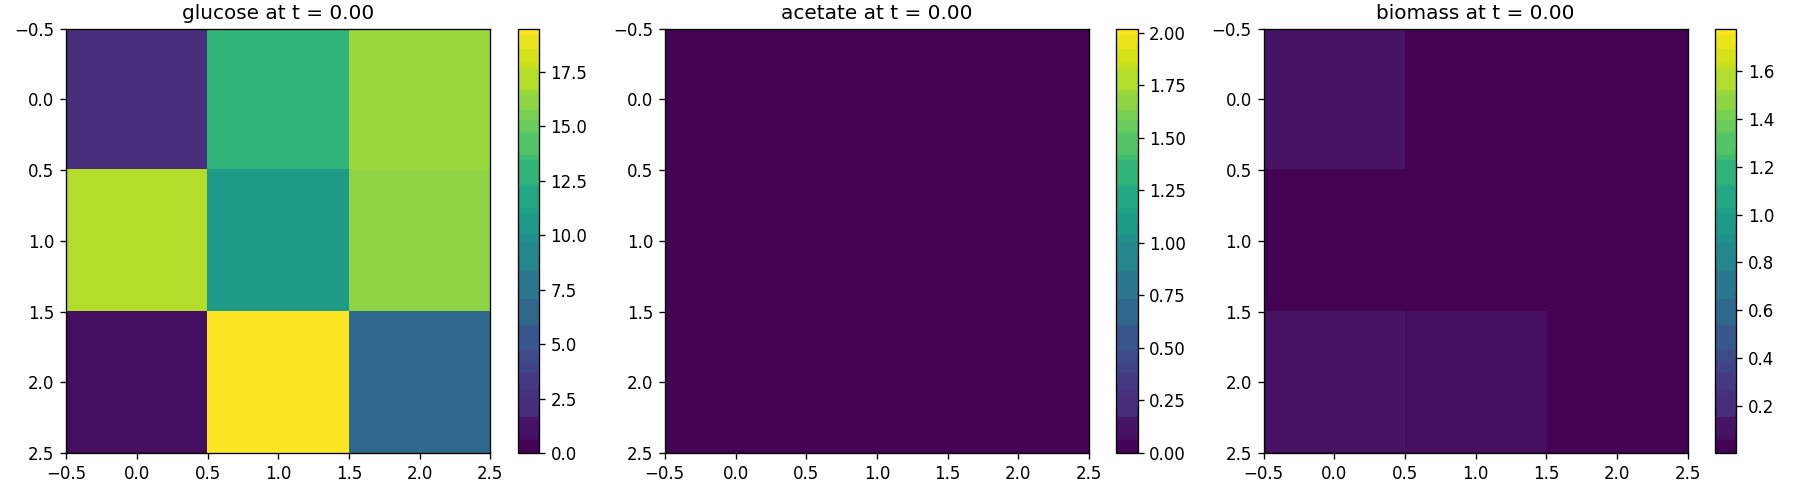

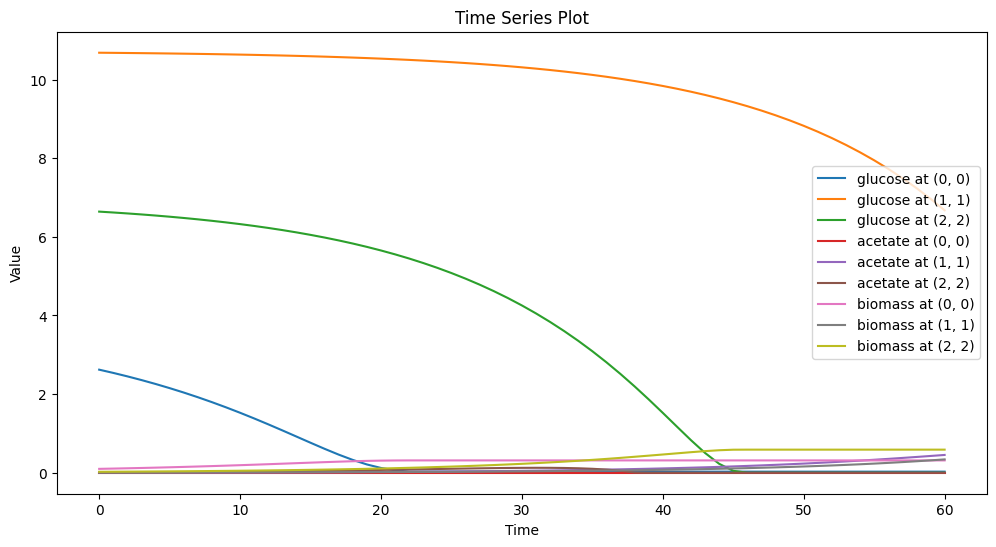

In [2]:
run_dfba_spatial()